# Mouse

In [59]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(0, "./scripts")
import numpy as np
import pandas as pd
from itertools import combinations, product
import joblib
import functions as f
from tqdm import tqdm
from matplotlib import pyplot as plt
import networkx as nx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Actual parametrisation

In [2]:
cfg = f.get_actual_parametrization("./config.json")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


In [3]:
cfg = f.update_cfg("./config.json", "TEST_NETWORK_LINK_PROB", 0.1, verbose=False)
cfg = f.update_cfg("./config.json", "TEST_NETWORK_SIZE", 500)

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


## TRRUST

Network construction

In [9]:
MOUSE_NETWORK_PATH = "./networks/mouse/trrust"

In [11]:
edges = pd.read_csv(os.path.join(MOUSE_NETWORK_PATH, "trrust_rawdata.mouse.tsv"), sep="\t", header=None)[[0, 1]]
edges.columns = ["Tf", "Tg"]
nodes = sorted(np.unique(np.concatenate((edges.Tf.unique(), edges.Tg.unique()))))
nodes = pd.DataFrame(data=range(len(nodes)), index=nodes, columns=["idx"])
print(f"Total genes number:\t{len(nodes)}")
print(f"Interactions number:\t{len(edges)}")
edges.head()

Total genes number:	2456
Interactions number:	7057


,Tf,Tg
0,Aatf,Bak1
1,Aatf,Bax
2,Aatf,Bbc3
3,Aatf,Cdkn1a
4,Aatf,Tpt1


In [12]:
edges_ = edges.join(nodes, on="Tf").join(nodes, on="Tg", lsuffix="_tf", rsuffix="_tg")
tf_nodes = edges_["idx_tf"].unique()
print(f"Total TF:\t{len(tf_nodes)}")
tg_nodes = edges_["idx_tg"].unique()
print(f"Total TG:\t{len(tg_nodes)}")
tf_x_tg_nodes = np.array(sorted(set(tf_nodes) & set(tg_nodes)))
print(f"TF and TG:\t{len(tf_x_tg_nodes)}")
tg_only_nodes = np.array(sorted(set(tg_nodes) - set(tf_nodes)))
print(f"TG only:\t{len(tg_only_nodes)}")
tf_only_nodes = np.array(sorted(set(tf_nodes) - set(tg_nodes)))
print(f"TF only:\t{len(tf_only_nodes)}")

meta = tf_nodes, tf_only_nodes, tg_nodes, tg_only_nodes, tf_x_tg_nodes
joblib.dump(meta, os.path.join(MOUSE_NETWORK_PATH, "meta.pkl"));

Total TF:	827
Total TG:	2092
TF and TG:	463
TG only:	1629
TF only:	364


In [13]:
def build_Tnet(edges, n):
    Tnet = np.zeros((n, n))
    Tnet[edges[:, 0], edges[:, 1]] = 1
    return Tnet

np_edges = edges_[["idx_tg", "idx_tf"]].values
interaction_matrix = build_Tnet(np_edges, len(nodes))

if not os.path.exists(MOUSE_NETWORK_PATH):
    os.mkdir(MOUSE_NETWORK_PATH)

joblib.dump(interaction_matrix, os.path.join(MOUSE_NETWORK_PATH, "interaction_matrix.gz"));

In [17]:
print(f"Total nodes: {interaction_matrix.shape[0]}")
print(f"Total edges: {interaction_matrix.sum():.0f}")

Total nodes: 2456
Total edges: 6490


In [18]:
%%time
motifs, counter = f.motif_search(cfg, interaction_matrix, batch_size=10000)
motifs_orig = motifs["030T"]
counter

CPU times: user 513 ms, sys: 120 ms, total: 634 ms
Wall time: 3.23 s


{'021C': 40969, '021D': 135077, '021U': 20789, '030C': 60, '030T': 1956}

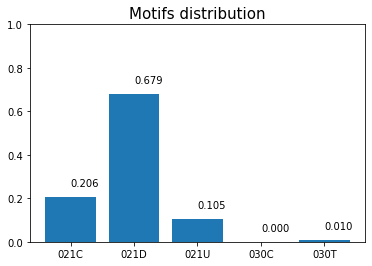

In [19]:
f.plot_motif_distr(counter)

Motif enrichment

In [21]:
noise_list = np.linspace(0, 80000, 11).astype(int)
score_list = []
for noise in tqdm(noise_list):
    shuffled_matrix = f.get_shuffled_matrix(interaction_matrix, noise)
    score_list.append(1-f.corruption_score(interaction_matrix, shuffled_matrix))

100%|██████████| 11/11 [00:33<00:00,  3.04s/it]


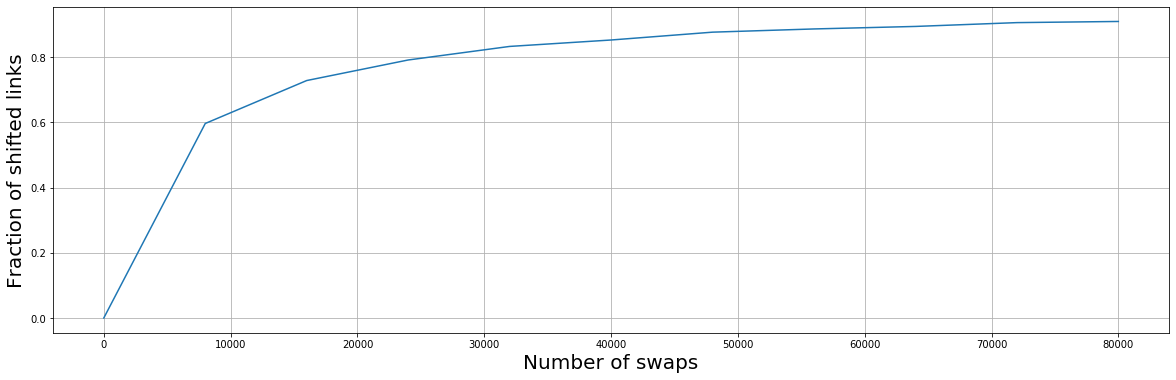

In [22]:
plt.figure(figsize=(20, 6))
plt.grid()
plt.ylabel("Fraction of shifted links", fontsize=20)
plt.xlabel("Number of swaps", fontsize=20)
plt.plot(noise_list, score_list);

In [33]:
ffl_nodes = list(set(sum([list(map(int, x.split("_"))) for x in motifs_orig], [])))
interaction_matrix_ffl = np.zeros((len(ffl_nodes), len(ffl_nodes)))
for motif in motifs_orig:
    motif = f.split_motif(motif)
    motif_new = list(ffl_nodes.index(x) for x in motif)
    interaction_matrix_ffl[np.ix_(motif_new, motif_new)] = \
    interaction_matrix[np.ix_(motif, motif)]
interaction_matrix_ffl.shape, interaction_matrix_ffl.sum()

((773, 773), 2697.0)

In [35]:
motifs_network = f.build_vmn(motifs_orig, verbose=True)

100%|██████████| 1911990/1911990 [00:09<00:00, 207426.81it/s]


In [36]:
V = nx.Graph(motifs_network)
nx.is_connected(V)

False

In [38]:
components = list(nx.algorithms.components.connected_components(V))
main_ffl_motifs = [motifs_orig[i] for i in components[0]]

In [39]:
len(main_ffl_motifs), len(main_ffl_motifs)/len(motifs_orig)

(1950, 0.9969325153374233)

In [23]:
interaction_matrix = joblib.load(os.path.join(MOUSE_NETWORK_PATH, "interaction_matrix.gz"))

In [5]:
N_SIMS = 1000
N_STEPS = 10
N_SWAPS = 40000
counters = f.generate_random_networks(cfg, interaction_matrix, N_SIMS, N_STEPS, N_SWAPS)

100%|██████████| 100/100 [05:01<00:00,  3.01s/it]


In [6]:
joblib.dump(counters, os.path.join(MOUSE_NETWORK_PATH, "shuffled_counters.gz"));

In [24]:
counters = joblib.load(os.path.join(MOUSE_NETWORK_PATH, "shuffled_counters.gz"));

100%|██████████| 1000/1000 [00:04<00:00, 245.35it/s]


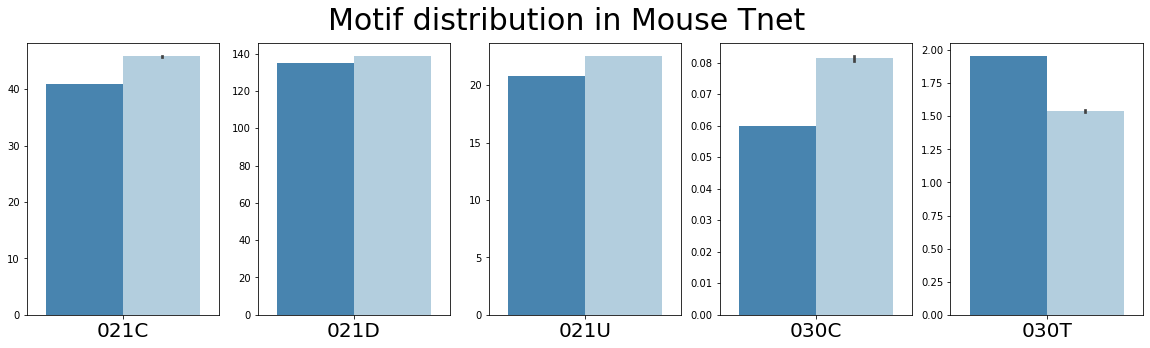

In [25]:
f.plot_distr(counters, counter, label="Motif distribution in Mouse Tnet", highlight=False);

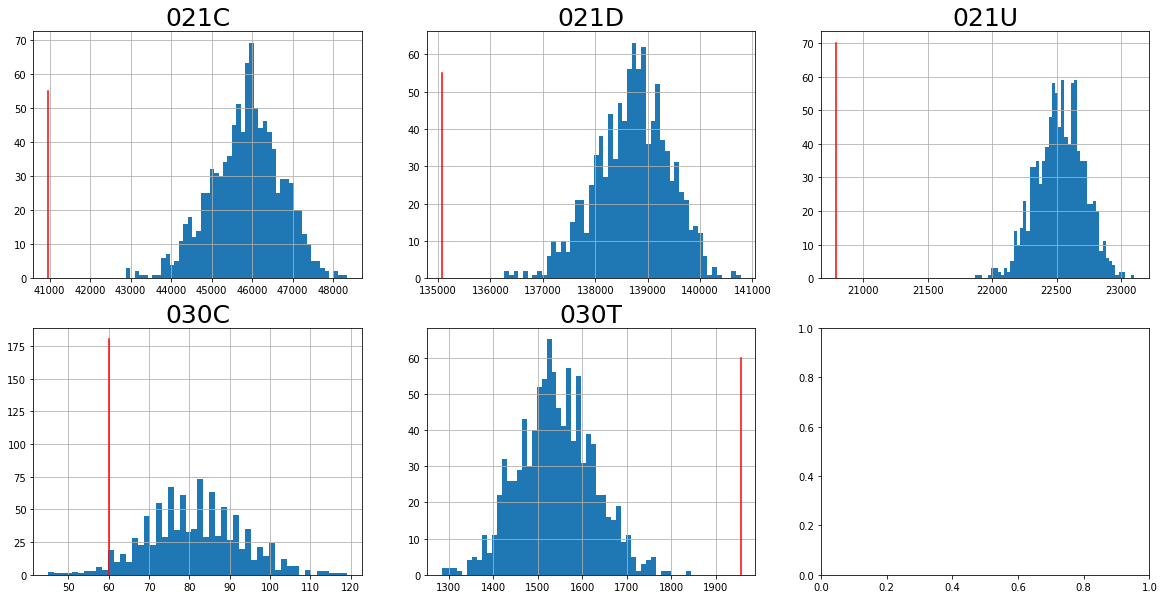

In [26]:
f.plot_distr_2(counters, counter, ticks = [55, 55, 70, 180, 60])

In [27]:
f.build_zscores_report(counters, counter)

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,40969,45851.5,862.984,-5.65775,0,< 0.01
021D,135077,138709,698.981,-5.19599,0,< 0.01
021U,20789,22527.9,184.583,-9.42046,0,< 0.01
030C,60,81.372,11.6947,-1.8275,0.033,non-significant
030T,1956,1540.48,84.4663,4.91938,0,< 0.01


# Regnetwork

In [28]:
MOUSE_NETWORK_PATH = "./networks/mouse/regnet/"

In [40]:
name_by_node = dict(pd.read_csv(os.path.join(MOUSE_NETWORK_PATH, "mouse.node"), sep="\t", header=None, index_col=0)[1])
node_by_name = {y: x for x, y in name_by_node.items()}

In [48]:
len(name_by_node)

21293

In [51]:
edges = pd.read_csv(os.path.join(MOUSE_NETWORK_PATH, "mouse.source"), sep="\t", header=None)
edges.sample(10)

,0,1,2,3
261306,mmu-miR-181d-5p,MIMAT0004324,Slmap,83997
8078,Cebpb,12608,Wfdc2,67701
148404,mmu-miR-106b-5p,MIMAT0000386,Ski,20481
202277,mmu-miR-217-5p,MIMAT0000679,Zfyve20,78287
122570,mmu-miR-10b-5p,MIMAT0000208,Bcl2l11,12125
250273,mmu-miR-665-3p,MIMAT0003733,Lbh,77889
84257,Zfp292,30046,Hoxa2,15399
22003,Fosl1,14283,Lrrn4cl,68852
99653,mmu-miR-27b-3p,MIMAT0000126,Galnt7,108150
305414,Irf1,16362,mmu-miR-1894-3p,MIMAT0007878


In [53]:
edges = pd.read_csv(
    os.path.join(MOUSE_NETWORK_PATH, "mouse.source"), sep="\t", header=None
)[[0, 2]]
edges.columns = ["Tf", "Tg"]
nodes = sorted(np.unique(np.concatenate((edges.Tf.unique(), edges.Tg.unique()))))
nodes = pd.DataFrame(data=range(len(nodes)), index=nodes, columns=["idx"])
print(f"Total genes number:\t{len(nodes)}")
print(f"Interactions number:\t{len(edges)}")
edges.head()

Total genes number:	20737
Interactions number:	323636


,Tf,Tg
0,LOC100047997,Npy
1,LOC100047997,Arc
2,LOC100047997,Bcl2
3,LOC100047997,Bdnf
4,LOC100047997,Crh


In [54]:
edges_ = edges.join(nodes, on="Tf").join(nodes, on="Tg", lsuffix="_tf", rsuffix="_tg")
tf_nodes = edges_["idx_tf"].unique()
print(f"Total TF:\t{len(tf_nodes)}")
tg_nodes = edges_["idx_tg"].unique()
print(f"Total TG:\t{len(tg_nodes)}")
tf_x_tg_nodes = np.array(sorted(set(tf_nodes) & set(tg_nodes)))
print(f"TF and TG:\t{len(tf_x_tg_nodes)}")
tg_only_nodes = np.array(sorted(set(tg_nodes) - set(tf_nodes)))
print(f"TG only:\t{len(tg_only_nodes)}")
tf_only_nodes = np.array(sorted(set(tf_nodes) - set(tg_nodes)))
print(f"TF only:\t{len(tf_only_nodes)}")

meta = tf_nodes, tf_only_nodes, tg_nodes, tg_only_nodes, tf_x_tg_nodes
joblib.dump(meta, os.path.join(MOUSE_NETWORK_PATH, "meta.pkl"));

Total TF:	1902
Total TG:	20714
TF and TG:	1879
TG only:	18835
TF only:	23


In [55]:
def build_Tnet(edges, n):
    Tnet = np.zeros((n, n))
    Tnet[edges[:, 0], edges[:, 1]] = 1
    return Tnet

np_edges = edges_[["idx_tg", "idx_tf"]].values
interaction_matrix = build_Tnet(np_edges, len(nodes))

if not os.path.exists(MOUSE_NETWORK_PATH):
    os.mkdir(MOUSE_NETWORK_PATH)

joblib.dump(interaction_matrix, os.path.join(MOUSE_NETWORK_PATH, "interaction_matrix.gz"));

In [56]:
print(f"Total nodes: {interaction_matrix.shape[0]}")
print(f"Total edges: {interaction_matrix.sum():.0f}")

Total nodes: 20737
Total edges: 323580


In [57]:
%%time
motifs, counter = f.motif_search(cfg, interaction_matrix, batch_size=10000, verbose=True)
motifs_orig = motifs["030T"]
counter

14482it [27:22,  8.82it/s]


CPU times: user 8min 14s, sys: 6min 44s, total: 14min 59s
Wall time: 38min 11s


{'021C': 6561521,
 '021D': 125097781,
 '021U': 4529991,
 '030C': 2834,
 '030T': 351063}

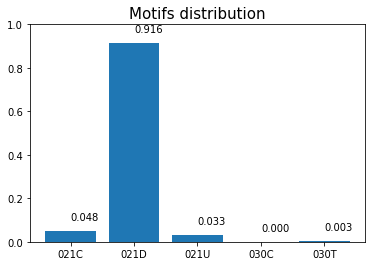

In [58]:
f.plot_motif_distr(counter)

Motif enrichment

In [63]:
noise_list = np.linspace(200000, 200000, 1).astype(int)
score_list = []
for noise in tqdm(noise_list):
    shuffled_matrix = f.get_shuffled_matrix(interaction_matrix, noise)
    score_list.append(1-f.corruption_score(interaction_matrix, shuffled_matrix))

100%|██████████| 1/1 [05:18<00:00, 318.39s/it]


In [64]:
score_list

[0.3547283515668459]

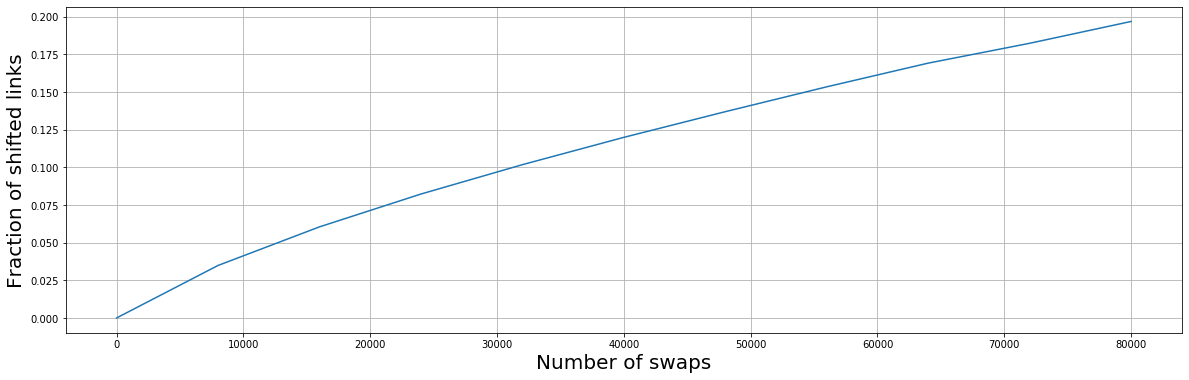

In [61]:
plt.figure(figsize=(20, 6))
plt.grid()
plt.ylabel("Fraction of shifted links", fontsize=20)
plt.xlabel("Number of swaps", fontsize=20)
plt.plot(noise_list, score_list);

In [33]:
ffl_nodes = list(set(sum([list(map(int, x.split("_"))) for x in motifs_orig], [])))
interaction_matrix_ffl = np.zeros((len(ffl_nodes), len(ffl_nodes)))
for motif in motifs_orig:
    motif = f.split_motif(motif)
    motif_new = list(ffl_nodes.index(x) for x in motif)
    interaction_matrix_ffl[np.ix_(motif_new, motif_new)] = \
    interaction_matrix[np.ix_(motif, motif)]
interaction_matrix_ffl.shape, interaction_matrix_ffl.sum()

((773, 773), 2697.0)

In [35]:
motifs_network = f.build_vmn(motifs_orig, verbose=True)

100%|██████████| 1911990/1911990 [00:09<00:00, 207426.81it/s]


In [36]:
V = nx.Graph(motifs_network)
nx.is_connected(V)

False

In [38]:
components = list(nx.algorithms.components.connected_components(V))
main_ffl_motifs = [motifs_orig[i] for i in components[0]]

In [39]:
len(main_ffl_motifs), len(main_ffl_motifs)/len(motifs_orig)

(1950, 0.9969325153374233)

In [ ]:
joblib==0.13.2
numba==0.53.0
numpy==1.17.2
pandas==0.25.1
tqdm==4.36.1

In [65]:
import joblib
import numba
import numpy
import pandas
import tqdm

In [72]:
print("joblib", joblib.__version__)
print("numba", numba.__version__)
print("numpy", numpy.__version__)
print("pandas", pandas.__version__)
print("tqdm", tqdm.__version__)

joblib 0.13.2
numba 0.53.0
numpy 1.17.2
pandas 0.25.1
tqdm 4.59.0


In [68]:
!which python

/opt/anaconda3/bin/python


In [69]:
!/opt/anaconda3/bin/python

Python 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)] :: Anaconda, Inc. on darwin
Type "help", "copyright", "credits" or "license" for more information.
>>> 
KeyboardInterrupt
>>> 
>>> 

In [71]:
!conda env export > env.yml